# Model Performance Evaluation
Work for Masters Thesis

Stanley Fujimoto

In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib inline

/Users/masaki/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
available_features_str = "aliscore,length,num_seqs,num_gaps,num_amino_acids,range,amino_acid_charged,amino_acid_uncharged,amino_acid_special,amino_acid_hydrophobic"
available_features = available_features_str.split( ',' )

## Data Prep

In [3]:
# load data
data = pickle.load( open( "../data/featurized_data.pickle", "rb" ) )

### split the data

In [4]:
# sdata is the scaled data, data is unscaled
sdata = data.copy()
sdata = shuffle( sdata )
sdata[ available_features ] = scale( sdata[ available_features ] )

## Model Testing

#### Model testing parameters

In [5]:
bootstrap_percentages_str = "1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100"
#bootstrap_percentages_str = "10,20,30,40,50,60,70,80,90,100"
bootstrap_percentages = map( float, bootstrap_percentages_str.split( ',' ) )
replicates = 20

In [6]:
# bootstrap function

def bootstrap( sdata, model, model_params = {} ):
    mdata = sdata.copy()
    #svm_data[ available_features ] = scale( svm_data[ available_features ] )
    #svm_train, svm_test = train_test_split( svm_data, test_size = 0.2 )
    #svm_x_test = test[ available_features ]
    #svm_y_test = test[ "class" ]

    acc_train = []
    acc_test = []
    for perc in bootstrap_percentages:
        # resample data
        num_instances = int( math.ceil( len( mdata ) * ( perc / 100 ) ) )

        acc_perc_train = []
        acc_perc_test = []

        for rep in range( replicates ):
            train, test = train_test_split( mdata, test_size = 0.2 )
            x_test = test[ available_features ]
            y_test = test[ "class" ]
            
            sub_train = train.sample( num_instances, replace = True )
            x_train = sub_train[ available_features ]
            y_train = sub_train[ "class" ]

            #print "\trep:", rep
            mod = model( **model_params )
            try:
                mod.fit( x_train, y_train )
            except ValueError as e:
                print x_train

            # train dataset
            preds = mod.predict( x_train )
            acc_perc_train.append( accuracy_score( preds, y_train ) )

            # test dataset
            preds = mod.predict( x_test )
            acc_perc_test.append( accuracy_score( preds, y_test ) )

        print "perc:", perc, np.mean( acc_perc_train ), np.mean( acc_perc_test ), np.std( acc_perc_train ), np.std( acc_perc_test )
        acc_train.append( acc_perc_train )
        acc_test.append( acc_perc_test )
    return acc_train, acc_test

In [7]:
# plot generation
def gen_plot( model, acc_train, acc_test, y_lim_min = 0.5, y_lim_max = 1.0 ):
    acc_train_ = np.asarray( acc_train )
    acc_test_ = np.asarray( acc_test )

    avgs_train = acc_train_.mean( axis = 1 )
    errs_train = acc_train_.std( axis = 1 )

    avgs_test = acc_test_.mean( axis = 1 )
    errs_test = acc_test_.std( axis = 1 )

    avgs = pd.DataFrame( [ avgs_train, avgs_test ] ).transpose()
    avgs.columns = [ "Train", "Test" ]
    avgs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = avgs.index )
    avgs.set_index( "perc", inplace = True )

    errs = pd.DataFrame( [ errs_train, errs_test ] ).transpose()
    errs.columns = [ "Train", "Test" ]
    errs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = errs.index )
    errs.set_index( "perc", inplace = True )

    fig, ax = plt.subplots()
    fig.set_size_inches( 12, 8, forward = True )
    plt.title( model + " accuracy" )
    plt.ylim( y_lim_min, y_lim_max )
    plt.xlabel( "% of total training set" )
    plt.ylabel( "% accuracy" )
    avgs.plot.line( ax = ax, color = [ 'b', 'r' ] )
    plt.fill_between( avgs.index, avgs[ "Train" ] - errs[ "Train" ], avgs[ "Train" ] + errs[ "Train" ], facecolor = 'blue', alpha = 0.2 )
    plt.fill_between( avgs.index, avgs[ "Test" ] - errs[ "Test" ], avgs[ "Test" ] + errs[ "Test" ], facecolor = 'red', alpha = 0.2 )
    plt.xticks( avgs.index.values, map( str, avgs.index.values ), fontsize = 8 )
    leg = plt.legend( fontsize = 8 )
    
    

### SVM

#### Bootstrap analysis

In [8]:
svm_acc_train, svm_acc_test = bootstrap( sdata, SVC, { "kernel" : "poly", "cache_size" : 4000 } )

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


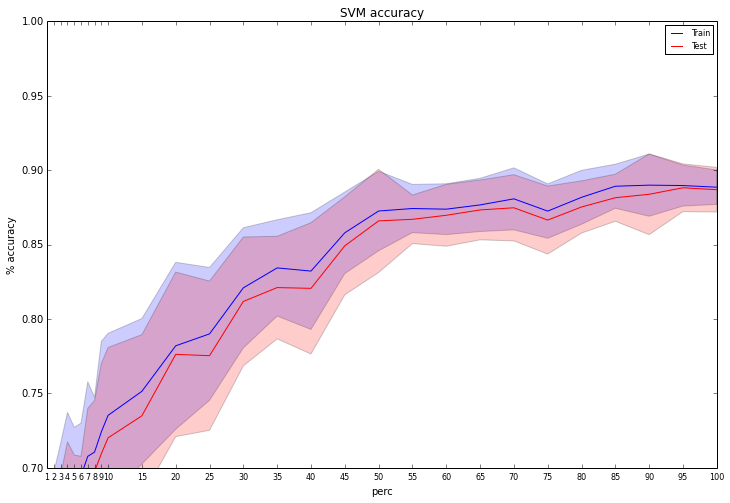

In [9]:
gen_plot( "SVM", svm_acc_train, svm_acc_test, y_lim_min = 0.7 )
plt.show()

### MLP

In [10]:
mlp_acc_train, mlp_acc_test = bootstrap( sdata, MLPClassifier )

1.0


/Library/Python/2.7/site-packages/numpy-1.11.0rc2-py2.7-macosx-10.11-intel.egg/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Users/masaki/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:560: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


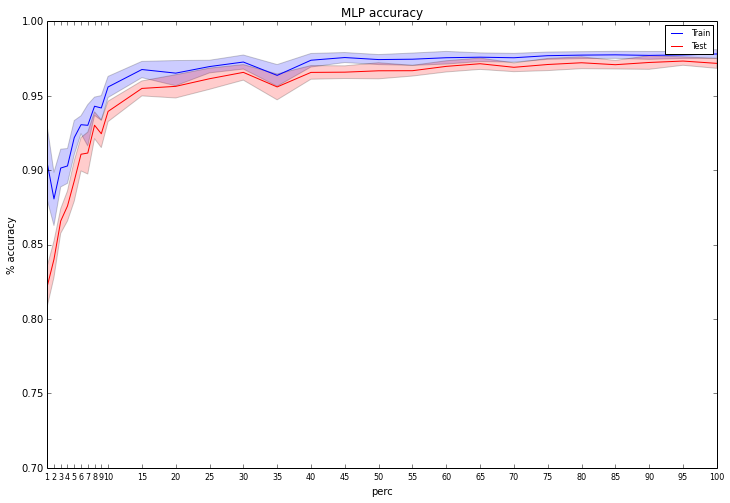

In [19]:
gen_plot( "MLP", mlp_acc_train, mlp_acc_test, y_lim_min = 0.7 )
plt.show()

### Logistic Regression

In [12]:
lr_acc_train, lr_acc_test = bootstrap( sdata, LogisticRegression )

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


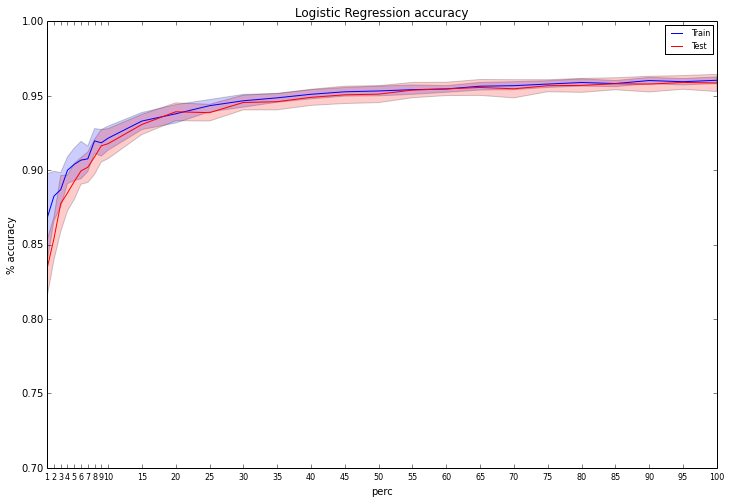

In [20]:
gen_plot( "Logistic Regression", lr_acc_train, lr_acc_test, y_lim_min = 0.7 )
plt.show()

### Random Forest

In [14]:
rf_acc_train, rf_acc_test = bootstrap( sdata, RandomForestClassifier )

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


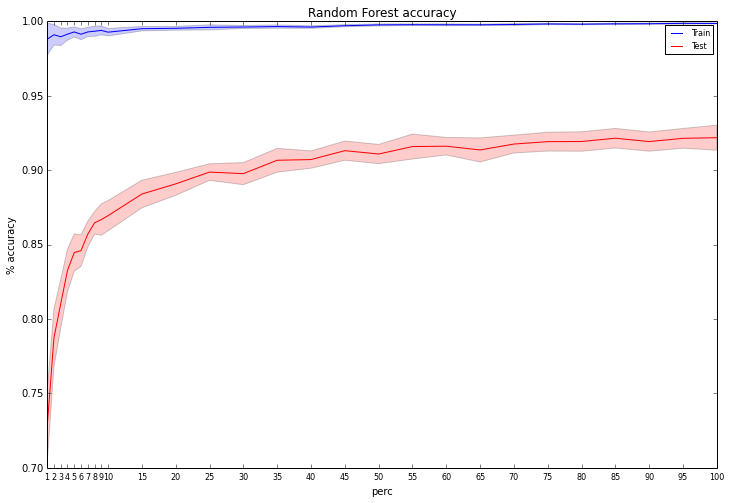

In [21]:
gen_plot( "Random Forest", rf_acc_train, rf_acc_test, y_lim_min = 0.7 )
plt.show()

### Naive Bayes

In [16]:
# naive bayes can't handle values that are <0, don't use scaled values 'sdata', use 'data'
nb_acc_train, nb_acc_test = bootstrap( data, MultinomialNB )

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


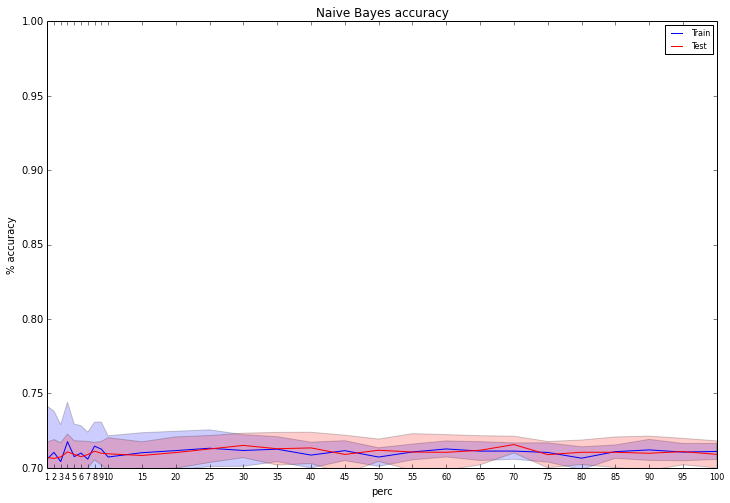

In [22]:
gen_plot( "Naive Bayes", nb_acc_train, nb_acc_test, y_lim_min = 0.7 )
plt.show()

### Meta

In [18]:
# code for meta classifier